In [1]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt

import tensorflow.keras as keras
import tensorflow as tf

from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier

from ML_Train.Vanilla_AE import create_vanilla_ae
from ML_Train.Variational_AE import create_autoencoder as create_conv_vae
from ML_Train.Convolutional_AE import create_autoencoder as create_conv_ae
from ML_Train.Variational_Vanilla_AE import create_autoencoder as create_vanilla_vae

# mse = keras.metrics.mean_squared_error(all_outputs,input_data)

Using TensorFlow backend.


In [2]:
keras.backend.clear_session()
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


In [64]:
train_featuresDF = pd.read_csv('data/featuresDF_train.csv')
train_stats = pd.read_csv('data/stats_train.csv')
train_vibState = pd.read_csv('data/vibState_train.csv')

valid_featuresDF = pd.read_csv('data/featuresDF_valid.csv')
valid_stats = pd.read_csv('data/stats_valid.csv')
valid_vibState = pd.read_csv('data/vibState_valid.csv')


In [65]:
train_vibState.values[:,1]

array(['Healthy', 'Healthy', 'Healthy', ..., 'Unhealthy', 'Unhealthy',
       'Unhealthy'], dtype=object)

In [67]:
X_train = train_featuresDF.values[:,1:1025].astype(np.float32)
enc = OrdinalEncoder()
Y_train = enc.fit_transform(train_vibState.values[:,1][...,np.newaxis])

X_valid = valid_featuresDF.values[:,1:1025].astype(np.float32)
Y_valid = enc.transform(valid_vibState.values[:,1][...,np.newaxis])

In [71]:
X_train_healthy = X_train[np.argwhere(Y_train.flatten()==1).flatten(),:]
Y_train_healthy = Y_train[np.argwhere(Y_train.flatten()==1).flatten()]
X_train_unhealthy = X_train[np.argwhere(Y_train.flatten()==0).flatten(),:]
Y_train_unhealthy = Y_train[np.argwhere(Y_train.flatten()==0).flatten()]


In [75]:
np.random.shuffle(X_train_healthy)
np.random.shuffle(X_valid_healthy)

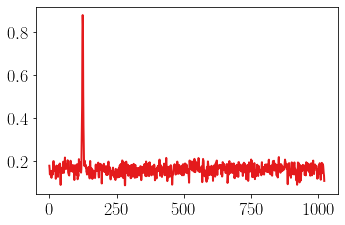

In [76]:
plt.plot(X_train_healthy[0,:])

In [51]:
pca = PCA(n_components=0.9)
X_condensed_pca = pca.fit_transform(X_healthy_train)
X_reconstructed_pca = pca.inverse_transform(X_condensed_pca)
mse_train = keras.metrics.mean_squared_error(X_reconstructed_pca,X_healthy_train)
X_healthy_pca = pca.transform(X_healthy)
X_healthy_pca = pca.inverse_transform(X_healthy_pca)
mse_healthy = keras.metrics.mean_squared_error(X_healthy_pca,X_healthy)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

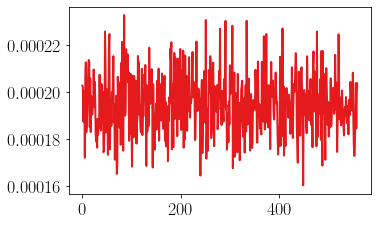

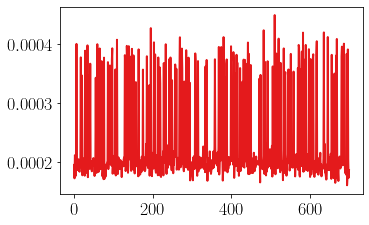

In [52]:
plt.plot(mse)
plt.show()

plt.plot(mse_healthy)
plt.show()

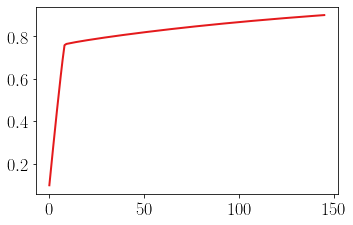

In [53]:
plt.plot(cumulative_variance)
plt.show()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (None, 25)                537625    
_________________________________________________________________
sequential_10 (Sequential)   (None, 1024)              538624    
Total params: 1,076,249
Trainable params: 1,076,249
Non-trainable params: 0
_________________________________________________________________
None


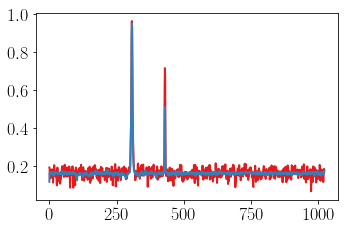

In [54]:
param_dict = {
    "hidden_nodes":[512,25],
    "input_shape":(1024,),
}
max_epochs = 20
batch_size = 32
verbose = 0

model,encoder,decoder = create_vanilla_ae(param_dict)

model.compile(loss='binary_crossentropy', 
              optimizer='adam')

loss = model.fit(
            X_train,X_train,
            validation_data=(X_test,X_test),
            epochs=max_epochs,
            batch_size=batch_size,
            verbose=verbose)

X_reconstructed_vanilla_ae = model.predict(X)

print(model.summary())

plt.plot(X[0,:])
plt.plot(X_reconstructed_vanilla_ae[0,:])
# plt.plot(X_reconstructed_pca[0,:])
plt.show()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 100), (None, 627400      input_5[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1024)         577024      model[1][2]                      
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 512)          524800      input_5[0][0]                    
____________________________________________________________________________________________

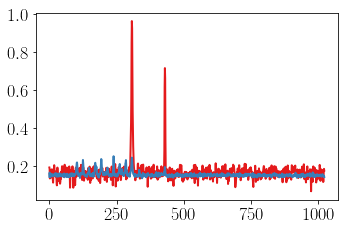

In [11]:
param_dict = {
    "hidden_nodes":[512],
    "input_shape":[1024,],
    "codings_size":100,
}

model,_,_ = create_vanilla_vae(param_dict)

model.compile(loss='binary_crossentropy', 
              optimizer='adam')

loss = model.fit(
            X_train,X_train,
            validation_data=(X_test,X_test),
            epochs=50,
            batch_size=128,
            verbose=verbose)

X_reconstructed_vanilla_vae = model.predict(X)

model.summary()

plt.plot(X[0,:])
plt.plot(X_reconstructed_vanilla_vae[0,:])
# plt.plot(X_reconstructed_pca[0,:])
plt.show()

In [12]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 100), (None, 627400      input_5[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1024)         577024      model[1][2]                      
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 512)          524800      input_5[0][0]                    
____________________________________________________________________________________________

In [13]:
model.input

<tf.Tensor 'input_5:0' shape=(None, 1024) dtype=float32>

In [14]:
filters=[20,20]
kernels = [9,3]
strides=[1,1,1]
dilation_rates=[1,1,1]
input_shape = [1024,1]
dense_nodes = [64]
codings_size = 8

param_dict = {
    "filters":filters,
    "kernels":kernels,
    "strides":strides,
    "dilation_rates":dilation_rates,
    "input_shape":input_shape,
    "dense_nodes":dense_nodes,
    "codings_size":codings_size
}

model,vae_encoder,vae_decoder = create_conv_vae(param_dict)

In [15]:
model.compile(loss='binary_crossentropy',optimizer='adam')
history = model.fit(X_train[...,np.newaxis],X_train[...,np.newaxis],
                    epochs=20,batch_size=64,
                    validation_data=[X_test[...,np.newaxis],X_test[...,np.newaxis]])

Train on 1120 samples, validate on 280 samples
Epoch 1/20
1120/1120 [==============================] - 4s 3ms/sample - loss: 0.5048 - val_loss: 0.4514
Epoch 2/20
1120/1120 [==============================] - 0s 285us/sample - loss: 0.4591 - val_loss: 0.4465
Epoch 3/20
1120/1120 [==============================] - 0s 272us/sample - loss: 0.4503 - val_loss: 0.4459
Epoch 4/20
1120/1120 [==============================] - 0s 265us/sample - loss: 0.4473 - val_loss: 0.4459
Epoch 5/20
1120/1120 [==============================] - 0s 274us/sample - loss: 0.4462 - val_loss: 0.4459
Epoch 6/20
1120/1120 [==============================] - 0s 279us/sample - loss: 0.4456 - val_loss: 0.4460
Epoch 7/20
1120/1120 [==============================] - 0s 274us/sample - loss: 0.4455 - val_loss: 0.4460
Epoch 8/20
1120/1120 [==============================] - 0s 277us/sample - loss: 0.4453 - val_loss: 0.4460
Epoch 9/20
1120/1120 [==============================] - 0s 275us/sample - loss: 0.4452 - val_loss: 0.4461
E

In [16]:
X_reconstructed_cnn_vae = model.predict(X[...,np.newaxis])
print(X_reconstructed_cnn_vae[0,:].shape)
print(X[0,:].shape)


(1024, 1)
(1024,)


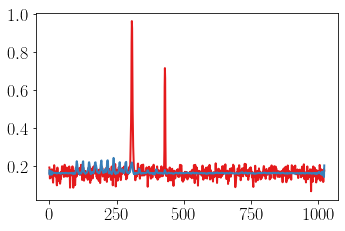

In [17]:
plt.plot(X[0,:])
plt.plot(X_reconstructed_cnn_vae[0,:])
# plt.plot(X_reconstructed_pca[0,:])
plt.show()

In [18]:
filters=[20]
kernels = [3]
strides=[1,1,1]
dilation_rates=[1,1,1]
input_shape = [1024,1]
dense_nodes = [32]
codings_size = 16

param_dict = {
    "filters":filters,
    "kernels":kernels,
    "strides":strides,
    "dilation_rates":dilation_rates,
    "input_shape":input_shape,
    "dense_nodes":dense_nodes,
    "codings_size":codings_size
}

model = create_conv_ae(param_dict)

In [19]:
model.compile(loss='mean_squared_error',optimizer='adam')
history = model.fit(X_train[...,np.newaxis],X_train[...,np.newaxis],
                    epochs=40,batch_size=64,
                    validation_data=[X_test[...,np.newaxis],X_test[...,np.newaxis]])

Train on 1120 samples, validate on 280 samples
Epoch 1/40
1120/1120 [==============================] - 1s 1ms/sample - loss: 0.1007 - val_loss: 0.0897
Epoch 2/40
1120/1120 [==============================] - 0s 161us/sample - loss: 0.0509 - val_loss: 0.0425
Epoch 3/40
1120/1120 [==============================] - 0s 166us/sample - loss: 0.0224 - val_loss: 0.0108
Epoch 4/40
1120/1120 [==============================] - 0s 163us/sample - loss: 0.0117 - val_loss: 0.0032
Epoch 5/40
1120/1120 [==============================] - 0s 168us/sample - loss: 0.0101 - val_loss: 0.0024
Epoch 6/40
1120/1120 [==============================] - 0s 162us/sample - loss: 0.0095 - val_loss: 0.0023
Epoch 7/40
1120/1120 [==============================] - 0s 162us/sample - loss: 0.0087 - val_loss: 0.0021
Epoch 8/40
1120/1120 [==============================] - 0s 163us/sample - loss: 0.0075 - val_loss: 0.0016
Epoch 9/40
1120/1120 [==============================] - 0s 158us/sample - loss: 0.0068 - val_loss: 0.0016
E

In [20]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 512, 20)           160       
_________________________________________________________________
sequential_7 (Sequential)    (None, 1024, 1)           1281      
Total params: 1,441
Trainable params: 1,401
Non-trainable params: 40
_________________________________________________________________


In [21]:
X_reconstructed_cnn_ae = model.predict(X[...,np.newaxis])
print(X_reconstructed_cnn_ae[0,:].shape)
print(X[0,:].shape)

(1024, 1)
(1024,)


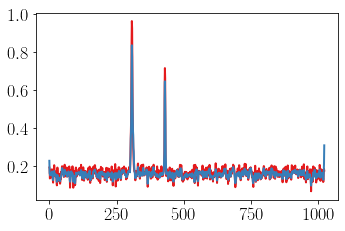

In [22]:
plt.plot(X[0,:])
plt.plot(X_reconstructed_cnn_ae[0,:])
# plt.plot(X_reconstructed_pca[0,:])
plt.show()

In [23]:
from tensorflow.keras import backend as K
from tensorflow import keras


class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 
    
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

tf.random.set_seed(42)
np.random.seed(42)

codings_size = 5

inputs = keras.layers.Input(shape=[1024])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(1024, activation="sigmoid")(x)
outputs = keras.layers.Reshape([1024])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 1024.)
variational_ae.compile(loss="mean_squared_error", optimizer="rmsprop", metrics=[rounded_accuracy])
# variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=50, batch_size=64,
                             validation_data=[X_test, X_test],verbose=1)

Train on 1120 samples, validate on 280 samples
Epoch 1/50
1120/1120 [==============================] - 1s 529us/sample - loss: 0.0571 - rounded_accuracy: 0.8811 - val_loss: 0.0106 - val_rounded_accuracy: 0.9948
Epoch 2/50
1120/1120 [==============================] - 0s 82us/sample - loss: 0.0115 - rounded_accuracy: 0.9949 - val_loss: 0.0088 - val_rounded_accuracy: 0.9948
Epoch 3/50
1120/1120 [==============================] - 0s 80us/sample - loss: 0.0100 - rounded_accuracy: 0.9949 - val_loss: 0.0078 - val_rounded_accuracy: 0.9948
Epoch 4/50
1120/1120 [==============================] - 0s 80us/sample - loss: 0.0085 - rounded_accuracy: 0.9949 - val_loss: 0.0068 - val_rounded_accuracy: 0.9948
Epoch 5/50
1120/1120 [==============================] - 0s 84us/sample - loss: 0.0092 - rounded_accuracy: 0.9949 - val_loss: 0.0063 - val_rounded_accuracy: 0.9948
Epoch 6/50
1120/1120 [==============================] - 0s 80us/sample - loss: 0.0071 - rounded_accuracy: 0.9946 - val_loss: 0.0060 - val

In [24]:
X_predicted = variational_ae.predict(X)

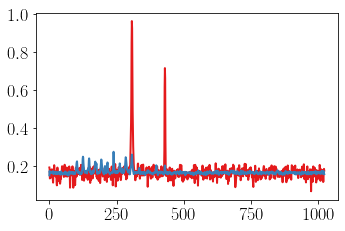

In [25]:
plt.plot(X[0,:])
plt.plot(X_predicted[0,:])
